In [1]:
# General imports
import numpy as np
import sys
basepath = "../"
sys.path.insert(0, basepath)

In [9]:
# Stuff for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["font.size"]=16
mpl.rcParams["font.family"]="sans-serif"
mpl.rcParams["text.usetex"]=True
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [4]:
#  Load the 5BZCat catalog
from lib.data import load_5bzcat, catbins, load_hotspots
dpath = "/Users/chiarabellenghi/PointSource/blazar_hotspots_correlation/data/"

cat = load_5bzcat(dpath)

# Load the hotspot list
hotspots = load_hotspots(dpath, hemisphere='south')

Load 5bzcat.csv
	Found 3469 sources


In [5]:
# Import stuff for the correlation analysis
from lib.correlation import Correlator, EventSample

In [6]:
# Initialize the Correlator object and the sample of hotspots to analyse.
# Note that catbins is useless for our analysis but the framework still requires it.
# scramble=0 will generate the pseudo experiment by scrambling the position of the sources only.
# boots=6 will generate the trial taking care of preserving the number of source,
# the portion of the sky and the latitude cut.
seed = 0
C = Correlator(
    cat, bins=catbins[-1],
    seed=seed,
    dec_range=(np.radians(-85),np.radians(-5)),
    mlat=np.radians(10),
    scramble=0, boots=6)
hs_sample = EventSample(hotspots)

sigmas = np.linspace(0.4, 0.7, 7)
pVal_thrs = np.linspace(3.5, 4.5, 3)
C.add_primary('hotspots', hs_sample, logpVal_thr_list=pVal_thrs, sigma_list=sigmas)


# The max_shift argument scrambles the sources within a maximum distance
# from the original position.
# Running 10000 trials takes ~ 5 minutes.
trials = C.trials(n_trials=10000, max_shift=np.radians(10))

- Setting galactic plane width to 10.0deg
Set scrambling to catalogue
Catalogue: 3469 sources
Applying cuts to the source catalogue:
	Sources in declination range: [-85.  -5.] degrees: 1214.
	Applying galactic plane cut...
	After galactic plane cut: 1177
	1177 sources above 0.00 (100.00%)
Remove sources that are in no bin:   0.00%
Analysis - Initialize with seed 0
Applying cuts to the event sample:
	Events in [-85.  -5.] degrees: 926
	Applying galactic plane cut...
	After galactic plane cut: 774
	Applying the pValue threshold cuts...
-log10(pVal) > 3.5: 44 hotspots will be analysed.
-log10(pVal) > 4.0: 19 hotspots will be analysed.
-log10(pVal) > 4.5: 9 hotspots will be analysed.
-- Calling function trials of <lib.correlation.Correlator object at 0x133a3b2b0>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  5.2min finished


--> Time (<lib.correlation.Correlator object at 0x133a3b2b0>, trials):  0d  0: 5:16.06


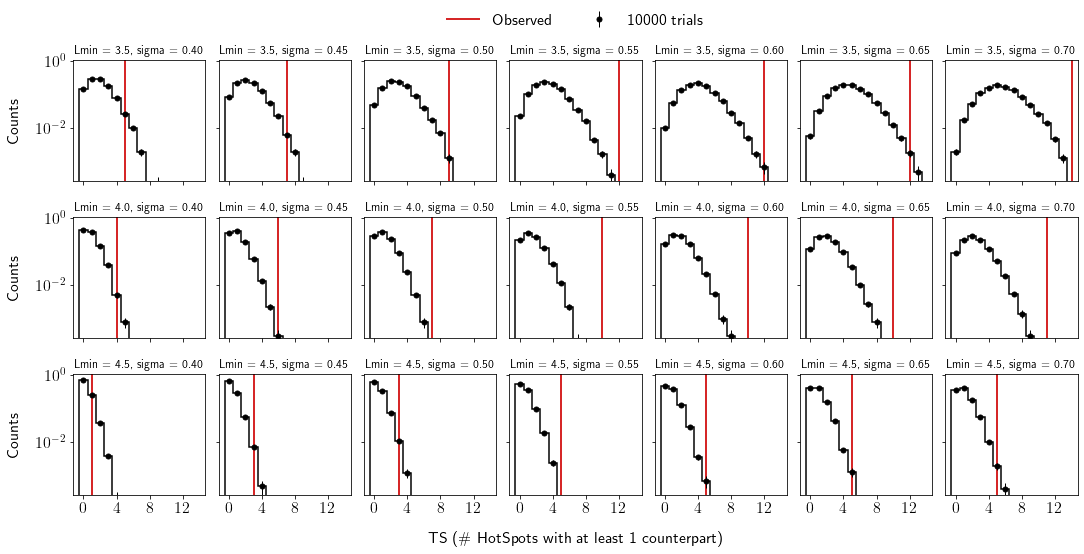

In [11]:
fig,ax = plt.subplots(nrows=3, ncols=7, sharex=True, sharey=True, figsize=(18,8))

ax[2][3].set_xlabel("TS (\# HotSpots with at least 1 counterpart)", labelpad=15)
for axis in ax[:,0]:
    axis.set_ylabel("Counts", labelpad=15)

ax = ax.flatten()
for i,key in enumerate(trials.dtype.names):
    observed_ts = C()[key]
    counts, bins = np.histogram(trials[key], bins=np.arange(0,15))
    binc = 0.5 * (bins[1:] + bins[:-1])-.5
    counts_norm = counts/np.sum(counts)
    ax[i].errorbar(binc, counts_norm, yerr=[np.sqrt(counts)/np.sum(counts),np.sqrt(counts)/np.sum(counts)],
                 fmt="o", color="k", zorder=10, markersize=5, elinewidth=1,
                 label=f"{trials[key].size} trials"
                )
    ax[i].hist(binc, bins-.5, weights=counts_norm, histtype='step', color='k', lw=1.5)
    ax[i].axvline(observed_ts, color="tab:red", label="Observed", lw=2)

    ax[i].set_yscale('log')

    ax[i].set_title(key[10:], fontsize=12)

ax[0].set_xticks([0,4,8,12])
ax[3].legend(frameon=False, loc="lower center", bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.subplots_adjust(hspace=0.3, wspace=.1)

plt.savefig("../plots/ts_distributions.png",
           dpi=500, bbox_inches="tight", facecolor="w")